In [1]:
def load_data_from_file(
    data_path,
    label_text_path=None,
    split_sep="\t",
    maxsplit=-1,
    text_pos=1,
    label_pos=0,
    return_dict=True,
):
    """Parse a tab-separated text file to a CSR label matrix and a list of text strings.

    Text format for each line:
    <comma-separated label indices><TAB><space-separated text string>
    Example: l_1,..,l_k<TAB>w_1 w_2 ... w_t
        l_k can be one of two format:
            (1) the zero-based index for the t-th relevant label
            (2) double colon separated label index and label relevance
        w_t is the t-th token in the string

    Args:
        data_path (str): Path to the text file
        label_text_path (str, optional): Path to the label text file.
            The main purpose is to obtain the number of labels. Default: None
        split_sep (str, optional): The separator. Default: "\t".
        maxsplit (int, optional): The max number of splits for each line. Default: -1 to denote full split
        text_pos (int, optional): The position of the text part in each line. Default: 1.
        label_pos (int, optional): The position of the text part in each line. Default: 0.
        return_dict (bool, optional): if True, return the parsed results in a dictionary. Default True

    Returns:
        if return_dict:
            {
                "label_matrix": (csr_matrix) label matrix with shape (N, L),
                "label_relevance": (csr_matrix) label relevance matrix with shape (N, L)
                                    have same sparsity pattern as label_matrix.
                "corpus": (list of str) the parsed instance text with length N.
            }
        else:
            (label_matrix, label_relevance, corpus)
    """
    if not os.path.isfile(data_path):
        raise FileNotFoundError(f"cannot find input text file at {data_path}")
    with open(data_path, "r", encoding="utf-8") as fin:
        label_strings, corpus = [], []
        for line in fin:
            parts = line.strip("\n")
            parts = parts.split(split_sep, maxsplit)
            if len(parts) < max(label_pos, text_pos) + 1:
                raise ValueError(f"corrupted line from input text file:\n{line}")
            label_strings.append(parts[label_pos])
            text_string = parts[text_pos]
            corpus.append(text_string)

    def parse_label_strings(label_strings, L):
        rows, cols, vals, rels = [], [], [], []

        # determine if relevance is provided
        has_rel = ":" in label_strings[0]

        for i, label in enumerate(label_strings):
            if has_rel:
                label_tuples = [tp.split(":") for tp in label.split(",")]
                label_list = list(map(int, [tp[0] for tp in label_tuples]))
                # label values are currently not being used.
                val_list = list(map(float, [tp[1] if tp[1] else 1.0 for tp in label_tuples]))
                rel_list = list(map(float, [tp[2] for tp in label_tuples]))
            else:
                label_list = list(map(int, label.split(",")))
                val_list = [1.0] * len(label_list)
                rel_list = []

            rows += [i] * len(label_list)
            cols += label_list
            vals += val_list
            rels += rel_list

        Y = smat.csr_matrix(
            (vals, (rows, cols)), shape=(len(label_strings), L), dtype=np.float32
        )
        if has_rel:
            R = smat.csr_matrix(
                (rels, (rows, cols)), shape=(len(label_strings), L), dtype=np.float32
            )
        else:
            R = None

        return Y, R

    if label_text_path is not None:
        if not os.path.isfile(label_text_path):
            raise FileNotFoundError(f"cannot find label text file at: {label_text_path}")
        # this is used to obtain the total number of labels L to construct Y with a correct shape
        L = sum(1 for line in open(label_text_path, "r", encoding="utf-8") if line)
        label_matrix, label_relevance = parse_label_strings(label_strings, L)
    else:
        label_matrix = None
        label_relevance = None

    if return_dict:
        return {
            "label_matrix": label_matrix,
            "label_relevance": label_relevance,
            "corpus": corpus,
        }
    else:
        return label_matrix, label_relevance, corpus

In [2]:
import numpy as np
import pandas as pd
import os
from ogb.nodeproppred import PygNodePropPredDataset
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.utils import degree, to_undirected
from transformers import BertTokenizer
import pickle
from torch_geometric.utils.convert import to_scipy_sparse_matrix
from multiprocessing.pool import ThreadPool
import statsmodels.api as sm
import pylab as py


data_name = 'products'

dataset = PygNodePropPredDataset(name = f'ogbn-{data_name}', root='../data') 

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = split_idx["train"], split_idx["valid"], split_idx["test"]
data = dataset[0] # pyg graph object

if data_name == 'arxiv':
    map_classID_className = pd.merge(left=pd.read_csv("../data/ogbn_arxiv/mapping/labelidx2arxivcategeory.csv.gz", index_col=0), 
                                     right=pd.read_csv("../data/ogbn_arxiv/mapping/category_name.csv", index_col=0), 
                                     how='left', 
                                     left_on='arxiv category', 
                                     right_on='arxiv category').drop('arxiv category', axis=1)\
                            .rename(columns={"arxiv category name": "category"})\
                            .squeeze()
    # Index of the samples used in the paper
    e2eg_vs_truth = 398
    bert_vs_e2eg = 31112
    giant_vs_e2eg = 68308
elif data_name == "products":
    map_classID_className = pd.read_csv("../data/ogbn_products/mapping/labelidx2productcategory.csv.gz", index_col=0)\
                            .rename(columns={"product category": "category"})\
                            .squeeze()
    # Index of the samples used in the paper
    e2eg_vs_truth = 235975
    bert_vs_e2eg = 349746
    giant_vs_e2eg = 359172

In [7]:
from collections import defaultdict


runs = 10

experiment_dir = "experiments"

y_true = data.y[test_idx]
compare_df = pd.DataFrame({"y_true": y_true.flatten()})
class_freq_dict = pd.Series(data.y.flatten()).value_counts(normalize=True)
compare_df["class_freq"] = [class_freq_dict.loc[i] for i in compare_df["y_true"]]
compare_df["y_true"] = compare_df["y_true"].apply(lambda x: map_classID_className.loc[x])
X_text = load_data_from_file(
    f"../data/proc_data_multi_task/ogbn-{data_name}/X.all.txt",
    label_text_path=None,
    text_pos=0,
)["corpus"]
X_text = [X_text[i] for i in test_idx]
compare_df["X_text"] = X_text
compare_df["node_degrees"] = degree(to_undirected(data.edge_index)[0])[test_idx]
compare_df["same_neighbor(%)"] = np.load(f"final_{data_name}.npy")
compare_df.index = test_idx.numpy()

# with open(f'count_tokens_{data_name}.pickle', 'rb') as handle:
#     count_tokens = pickle.load(handle)
# compare_df["text_length"] = [count_tokens[i] for i in test_idx]

def combine_results(x, y):
    if x == y and x == True:
        return True
    elif x == y and x == False:
        return False
    else:
        return float("nan")

for run in range(0, runs):
    # Extract the predictions
    my_pred_dir = f"{experiment_dir}/{data_name}_distilbert/run{run}"
    for file in os.listdir(my_pred_dir):
        # Get predictions from e2e model and ensemble predictions over runs
        filename = os.fsdecode(file)
        if filename.endswith("prediction_mclass"):
            compare_df["my_pred"] = np.load(f"{my_pred_dir}/{filename}").argmax(axis=1)
            
    bert_pred_dir = f"{experiment_dir}/bert_classifier_{data_name}/run{run}"
    for file in os.listdir(bert_pred_dir):
        # Get predictions from bert model and ensemble predictions over runs
        filename = os.fsdecode(file)
        if filename.endswith(".npy"):
            compare_df["bert_pred"] = np.load(f"{bert_pred_dir}/{filename}")
            
    giant_pred_dir = f"{experiment_dir}/giant_original_{data_name}/run{run}"
    for file in os.listdir(giant_pred_dir):
        # Get predictions from bert model and ensemble predictions over runs
        filename = os.fsdecode(file)
        if filename.endswith(".npy"):
            compare_df["giant_pred"] = np.load(f"{giant_pred_dir}/{filename}").flatten()[test_idx]
    
    # Convert idx to name and combine over runs
    for pred in ["my_pred", "bert_pred", "giant_pred"]:
        # Replace category index with category name
        compare_df[pred] = compare_df[pred].apply(lambda x: map_classID_className.loc[x])
        if run == 0:
            # Whether each prediction is correct. 
            compare_df[pred + "_correct"] = compare_df[pred] == compare_df["y_true"]
        else:
            # Combine for multiple runs. 
            # Correct if all runs are correct
            # Wrong if all runs are wrong
            # Otherwise discard, bc it depends on randomness
            compare_df[pred + "_correct"] = [combine_results(x, y) 
                                             for x,y in zip(compare_df[pred] == compare_df["y_true"].tolist(),
                                                            compare_df[pred + "_correct"].tolist())]
compare_df = compare_df.dropna()
compare_df = compare_df.astype({'my_pred_correct': 'bool', 'bert_pred_correct': 'bool', 'giant_pred_correct': 'bool'})



# Add percentage of neighbors that has the same class
adj = to_scipy_sparse_matrix(to_undirected(data.edge_index))
def get_neightbors(node):
    return adj.getrow(node).indices

# def get_percentage_same_neighbor(node):
#     neighbors_classes = data.y[get_neightbors(node)]
#     node_class = data.y[node]
#     return np.count_nonzero(neighbors_classes == node_class) / len(neighbors_classes)

# def save_percentage_same_neighbor_chunk(start_id, end_id):
#     nodes = test_idx[start_id:end_id]
#     np.save(f"{start_id}_{end_id-1}.npy", np.array([get_percentage_same_neighbor(node) for node in nodes]))

# chunk=5000
# futures = []
# pool = ThreadPool(7)
# for i in range(0,  compare_df.shape[0], chunk):
#     futures.append(pool.apply_async(save_percentage_same_neighbor_chunk, (i, min(i+chunk, compare_df.shape[0])))) 
# pool.close()
# pool.join()
# for future in futures:
#     future.get()

# combine = []
# for i in range(0,  compare_df.shape[0], chunk):
#     combine.append(np.load(f"{i}_{min(i+chunk-1, compare_df.shape[0]-1)}.npy"))
# compare_df["same_neighbor(%)"] = np.concatenate(combine)

compare_df.to_csv(f"compare_df_{data_name}.csv")

# compare_df = pd.read_csv(f"compare_df_{data_name}.csv")

In [8]:
result_dict = {"e2e_wrong": ((compare_df["my_pred_correct"]==False)),
"all_correct": ((compare_df["my_pred_correct"]==True)) & ((compare_df["bert_pred_correct"]==True)) & ((compare_df["giant_pred_correct"]==True)),
"bert_correct_only": (~(compare_df["my_pred_correct"]==True)) & ((compare_df["bert_pred_correct"]==True)) & (~(compare_df["giant_pred_correct"]==True)),
"giant_correct_only": (~(compare_df["my_pred_correct"]==True)) & (~(compare_df["bert_pred_correct"]==True)) & ((compare_df["giant_pred_correct"]==True)),
"e2e_correct_only": ((compare_df["my_pred_correct"]==True)) & (~(compare_df["bert_pred_correct"]==True)) & (~(compare_df["giant_pred_correct"]==True)),
"all_wrong": (~(compare_df["my_pred_correct"]==True)) & (~(compare_df["bert_pred_correct"]==True)) & (~(compare_df["giant_pred_correct"]==True)),
"e2e_correct_bert_wrong": ((compare_df["my_pred_correct"]==True)) & (~(compare_df["bert_pred_correct"]==True)),
"e2e_correct_giant_wrong": ((compare_df["my_pred_correct"]==True)) & (~(compare_df["giant_pred_correct"]==True)),
"e2e_wrong_bert_correct": (~(compare_df["my_pred_correct"]==True)) & ((compare_df["bert_pred_correct"]==True)),
"e2e_wrong_giant_correct": (~(compare_df["my_pred_correct"]==True)) & ((compare_df["giant_pred_correct"]==True)),
"e2e_correct_bert_correct": ((compare_df["my_pred_correct"]==True)) & ((compare_df["bert_pred_correct"]==True)),
"e2e_correct_giant_correct": ((compare_df["my_pred_correct"]==True)) & ((compare_df["giant_pred_correct"]==True)),
"all": np.full((compare_df.shape[0],), True)
}

print("Dropped samples: ", 100 - compare_df.shape[0] / test_idx.shape[0] * 100)


Dropped samples:  33.46396510581806


### E2E wrong

In [9]:
df = compare_df[result_dict['all_wrong']][["X_text", "same_neighbor(%)", 'my_pred', 'bert_pred', "giant_pred_correct", 'y_true', "class_freq"]]


In [10]:
compare_df[result_dict['all_wrong']][["same_neighbor(%)", 'my_pred', 'bert_pred', 'y_true', "class_freq", 'node_degrees']].head()


,same_neighbor(%),my_pred,bert_pred,y_true,class_freq,node_degrees
235939,0.990909,Books,Industrial & Scientific,Automotive,0.034134,110.0
235967,0.854167,Baby Products,Health & Personal Care,Baby,0.013271,48.0
235975,0.148148,Home & Kitchen,Home & Kitchen,"Patio, Lawn & Garden",0.016625,81.0
235980,0.363636,Baby Products,Sports & Outdoors,Baby,0.013271,22.0
235986,0.666667,CDs & Vinyl,CDs & Vinyl,Books,0.273149,3.0


In [11]:
pd.set_option('display.max_colwidth', None)
central_node = e2eg_vs_truth
compare_df[result_dict['all_wrong']][["X_text", "same_neighbor(%)", 'my_pred', 'bert_pred', 'y_true', "class_freq", 'node_degrees']].loc[central_node]

X_text              chill it - wine bag beer bottle cooler & ice chiller freezable carrier (violet) sleek, contemporary and cool - the new freezable chill bags have been a huge hit! keep these bags in the freezer and they become instant coolers for not only wine, but champagne, vodkas, beer, or whatever other beverages you want to keep chilled. there are six bold, eye-catching colors to choose from. these cosmopolitan bags are festive, fun, and make for unique gift items. please do not forget to reuse them. show up at your hosts or party with this beautiful classy and cool bag, moreover your wine will arrive chilled and ready to serve.....
same_neighbor(%)                                                                                                                                                                                                                                                                                                                                                

In [12]:
import networkx as nx
import torch
from torch_geometric.utils import to_networkx, is_undirected, to_undirected, k_hop_subgraph, subgraph
from collections import defaultdict
import matplotlib.cm as cm
from matplotlib.colors import Normalize

num_hops=2

edge_index = data.edge_index
if not is_undirected(edge_index):
    edge_index = to_undirected(edge_index)
Degree = degree(edge_index[0])
Filtered_idx = torch.where(Degree < 300)[0]

edge_index, _ = subgraph(Filtered_idx, edge_index=edge_index)

node_subset, edge_index, _, _ = k_hop_subgraph(node_idx=central_node,   # torch.tensor(df.index.values),
                                                       num_hops=num_hops,
                                                       edge_index=edge_index)


    
G = nx.MultiGraph()
G.add_nodes_from(list(node_subset.numpy()))
G.add_edges_from([tuple(x) for x in edge_index.t().numpy()])


len(node_subset)


1995

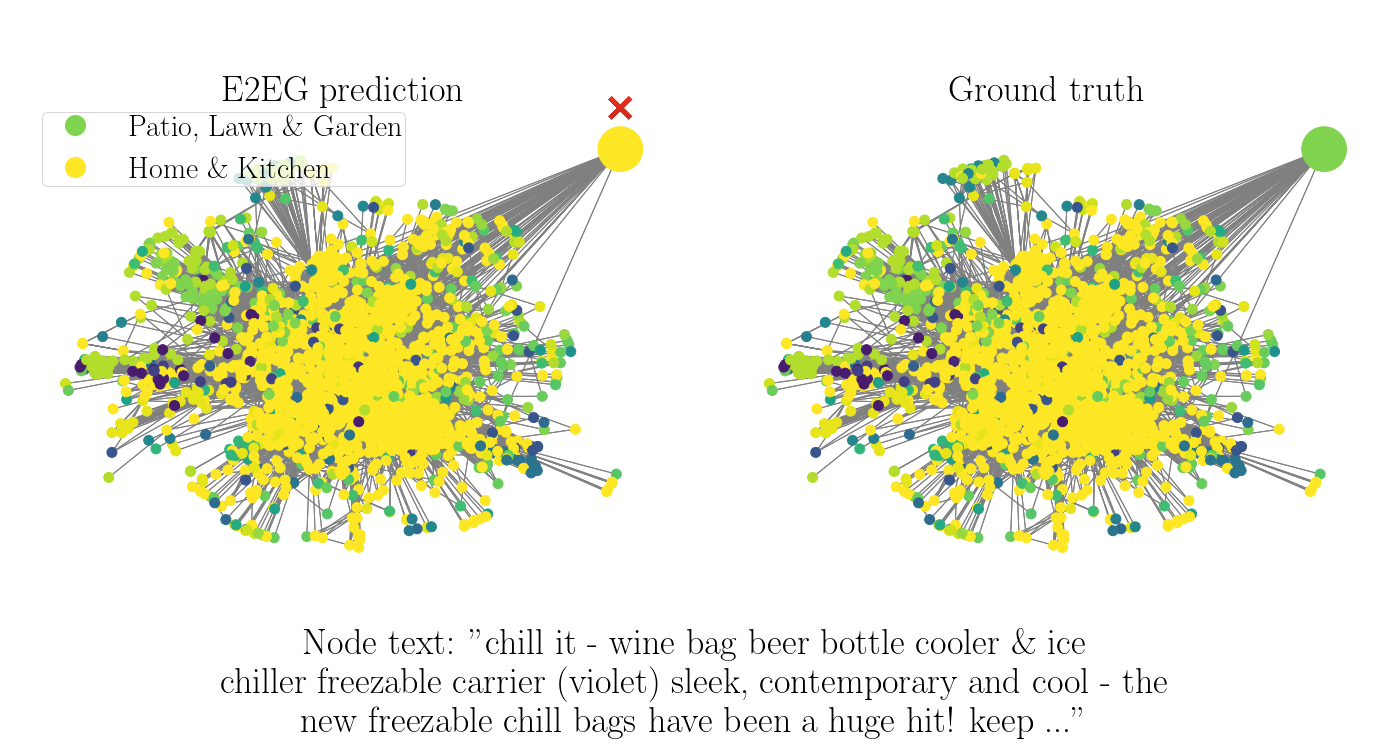

In [22]:
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 30, 'font.weight': 'regular', 'font.family': 'Times Roman'})


if data_name == 'arxiv':
    correct_wrong_zoom = 0.25
    correct_wrong_location_shift = np.array([0, 0.19])
    legend_loc = (0.03,0.75)
    color_scheme = "tab20"
elif data_name == 'products':
    correct_wrong_zoom = 0.25
    correct_wrong_location_shift = np.array([0, 0.19])
    legend_loc = (0.03,0.75)
    color_scheme = "viridis_r"
    

unique_node_class = np.unique(data.y[node_subset.numpy()].numpy().flatten())
reindex_node_classes = [np.where(unique_node_class == x)[0][0] for x in data.y[node_subset.numpy()].numpy().flatten()]

cmap = cm.get_cmap(color_scheme)
norm = Normalize(vmin=0, vmax=len(unique_node_class) + 1)
color_map_all = {node_class: cmap(norm(node_class)) for node_class in range(0, len(unique_node_class) + 1)}

color_map_ytrue = [color_map_all[x] for x in reindex_node_classes]


my_pred_central_node_class = map_classID_className[map_classID_className == compare_df.loc[central_node, "my_pred"]].index[0]
y_true_central_node_class = map_classID_className[map_classID_className == compare_df.loc[central_node, "y_true"]].index[0]

reindex_y_true_central_node_class = np.where(unique_node_class == y_true_central_node_class)[0][0]
reindex_my_pred_central_node_class = np.where(unique_node_class == my_pred_central_node_class)[0][0]

color_map_mine = [color_map_all[x] for x in reindex_node_classes]
color_map_mine[np.where(node_subset.numpy() == central_node)[0][0]] = \
        color_map_all[reindex_my_pred_central_node_class]






fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
node_text = compare_df.loc[central_node, "X_text"].replace('&', '\&')
fig.suptitle(f'Node text: \"{" ".join(node_text.split()[:10])} \n{" ".join(node_text.split()[10:20])} \n{" ".join(node_text.split()[20:30])} ...\"', 
             y=-0.01)
np.random.seed(1)

normal_node_size = 100
node_sizes = np.ones((node_subset.shape[0],) ) * normal_node_size
node_sizes[np.where(node_subset.numpy() == central_node)[0][0]] = normal_node_size*20


center_loc = np.array([1,1])

pos=nx.spring_layout(G)
pos[central_node] = center_loc


nx.draw(G, node_size=node_sizes, pos=pos, edge_color='gray', node_color=color_map_mine, ax=ax1)
nx.draw(G, node_size=node_sizes, pos=pos, edge_color='gray', node_color=color_map_ytrue, ax=ax2)
ax1.set_title("E2EG prediction")
ax2.set_title("Ground truth")

# reading the image
correct = plt.imread('../visualization/analysis/correct.png')
wrong = plt.imread('../visualization/analysis/wrong.png')
# OffsetBox
correct_box = OffsetImage(correct, zoom=correct_wrong_zoom)
wrong_box = OffsetImage(wrong, zoom=correct_wrong_zoom)

ab = AnnotationBbox(wrong_box, center_loc + correct_wrong_location_shift, frameon=False)
ax1.add_artist(ab)


legend_elements = [Line2D([0], [0], marker='o', color=color_map_all[reindex_y_true_central_node_class], 
                          label=compare_df.loc[central_node, "y_true"].replace('&', '\&'),
                          markerfacecolor=color_map_all[reindex_y_true_central_node_class],
                          markersize=20, linestyle=""),
                  Line2D([0], [0], marker='o', color=color_map_all[reindex_my_pred_central_node_class], 
                          label=compare_df.loc[central_node, "my_pred"].replace('&', '\&'),
                          markerfacecolor=color_map_all[reindex_my_pred_central_node_class],
                          markersize=20, linestyle="")]
plt.figlegend(handles=legend_elements, loc=legend_loc, borderpad=0.1)

plt.tight_layout()

plt.savefig(f"../visualization/analysis/E2EGvsTruth_{data_name}_{central_node}central_{num_hops}hop.pdf",
           bbox_inches='tight')

### E2E vs BERT

In [61]:
df = compare_df[result_dict['e2e_correct_bert_wrong']][["X_text", "same_neighbor(%)", 'my_pred', 'bert_pred', "giant_pred_correct", 'y_true', "class_freq"]]
df["giant_pred_correct"].value_counts(normalize=True)*100


True     95.458404
False     4.541596
Name: giant_pred_correct, dtype: float64

In [62]:
compare_df[result_dict['e2e_correct_bert_wrong']][["same_neighbor(%)", 'my_pred', 'bert_pred', 'y_true', "class_freq", 'node_degrees']].head()


,same_neighbor(%),my_pred,bert_pred,y_true,class_freq,node_degrees
237525,0.901961,Tools & Home Improvement,Sports & Outdoors,Tools & Home Improvement,0.032991,102.0
237621,0.576087,Sports & Outdoors,Office Products,Sports & Outdoors,0.061682,92.0
240303,0.666667,Sports & Outdoors,Home & Kitchen,Sports & Outdoors,0.061682,3.0
240672,0.941748,Electronics,Tools & Home Improvement,Electronics,0.053852,103.0
243467,1.000000,Office Products,Health & Personal Care,Office Products,0.020016,5.0


In [63]:
pd.set_option('display.max_colwidth', None)
central_node = bert_vs_e2eg
compare_df[result_dict['e2e_correct_bert_wrong']][["X_text", "same_neighbor(%)", 'my_pred', 'bert_pred', 'y_true', "class_freq", 'node_degrees']].loc[central_node]

X_text              na rebecca carey lyles grew up in wyoming, the setting for her kate neilson novels. she and her husband, steve, currently live in idaho (not to be confused with iowa!), the beautiful state that borders wyoming on the west. in addition to writing fiction and nonfiction, she serves as an editor and a mentor to aspiring authors and as a coach for women transitioning from prison to “the outside.” winds of freedom is the sequel to the award-winning first book in the kate neilson series, winds of wyoming.
same_neighbor(%)                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [64]:
import networkx as nx
import torch
from torch_geometric.utils import to_networkx, is_undirected, to_undirected, k_hop_subgraph, subgraph
from collections import defaultdict
import matplotlib.cm as cm
from matplotlib.colors import Normalize

num_hops=2

edge_index = data.edge_index
if not is_undirected(edge_index):
    edge_index = to_undirected(edge_index)
Degree = degree(edge_index[0])
Filtered_idx = torch.where(Degree < 300)[0]

edge_index, _ = subgraph(Filtered_idx, edge_index=edge_index)

node_subset, edge_index, _, _ = k_hop_subgraph(node_idx=central_node,   # torch.tensor(df.index.values),
                                                       num_hops=num_hops,
                                                       edge_index=edge_index)


    
G = nx.MultiGraph()
G.add_nodes_from(list(node_subset.numpy()))
G.add_edges_from([tuple(x) for x in edge_index.t().numpy()])


len(node_subset)


752

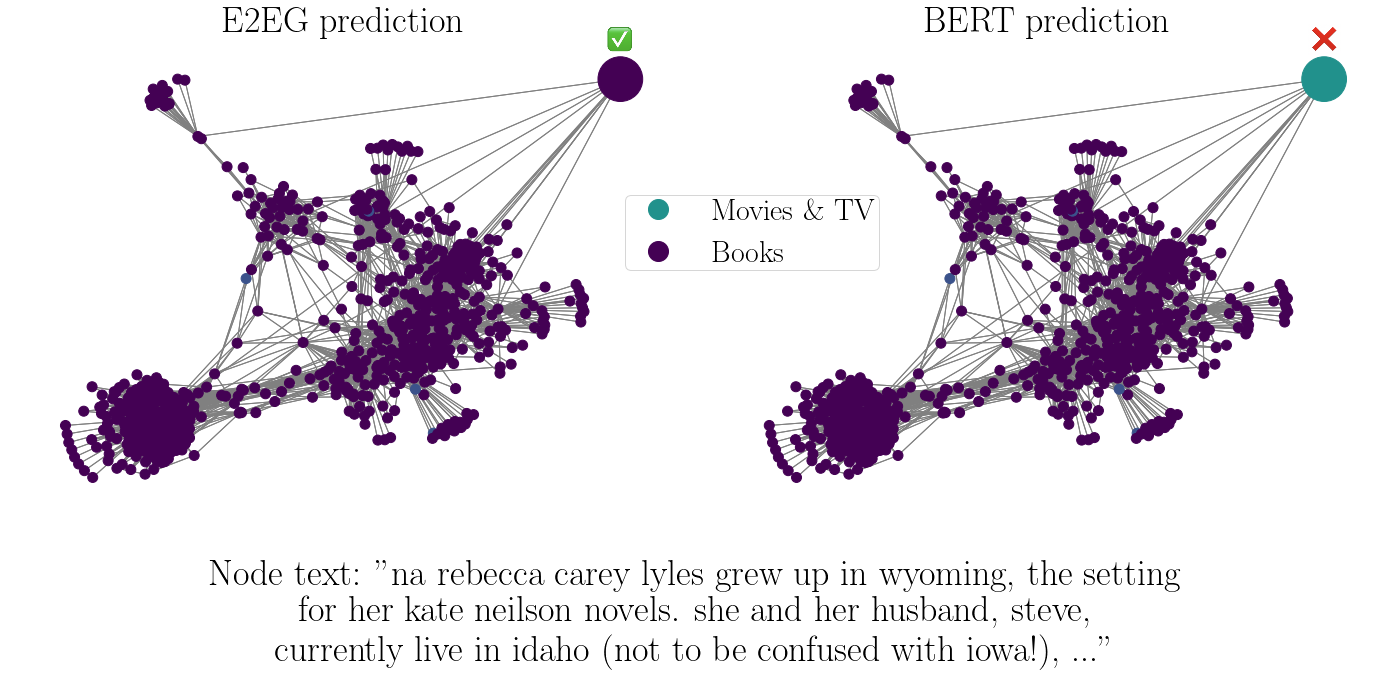

In [65]:
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 30, 'font.weight': 'regular', 'font.family': 'Times Roman'})

if data_name == 'arxiv':
    correct_wrong_zoom = 0.25
    correct_wrong_location_shift = np.array([0, 0.15])
    legend_loc = (0.03,0.75)
    color_scheme = 'viridis_r'
elif data_name == 'products':
    correct_wrong_zoom = 0.25
    correct_wrong_location_shift = np.array([0, 0.15])
    legend_loc = (0.45,0.6)
    color_scheme = "viridis"
    
my_pred_central_node_class = map_classID_className[map_classID_className == compare_df.loc[central_node, "my_pred"]].index[0]
bert_pred_central_node_class = map_classID_className[map_classID_className == compare_df.loc[central_node, "bert_pred"]].index[0]

unique_node_class = np.unique(data.y[node_subset.numpy()].numpy().flatten())
if bert_pred_central_node_class not in unique_node_class:
    unique_node_class = np.append(unique_node_class, bert_pred_central_node_class)
    
reindex_node_classes = [np.where(unique_node_class == x)[0][0] for x in data.y[node_subset.numpy()].numpy().flatten()]

cmap = cm.get_cmap(color_scheme)
norm = Normalize(vmin=0, vmax=len(unique_node_class) + 1)
color_map_all = {node_class: cmap(norm(node_class)) for node_class in range(0, len(unique_node_class) + 1)}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
node_text = compare_df.loc[central_node, "X_text"].replace('&', '\&')
fig.suptitle(f'Node text: \"{" ".join(node_text.split()[:10])} \n{" ".join(node_text.split()[10:20])} \n{" ".join(node_text.split()[20:30])} ...\"', 
             y=-0.01)
np.random.seed(1)

normal_node_size = 100
node_sizes = np.ones((node_subset.shape[0],) ) * normal_node_size
node_sizes[np.where(node_subset.numpy() == central_node)[0][0]] = normal_node_size*20

reindex_my_pred_central_node_class = np.where(unique_node_class == my_pred_central_node_class)[0][0]
reindex_bert_pred_central_node_class = np.where(unique_node_class == bert_pred_central_node_class)[0][0]

color_map_mine = [color_map_all[x] for x in reindex_node_classes]
color_map_bert = [color_map_all[x] for x in reindex_node_classes]
color_map_bert[np.where(node_subset.numpy() == central_node)[0][0]] = \
        color_map_all[reindex_bert_pred_central_node_class]

center_loc = np.array([1,1])

pos=nx.spring_layout(G)
pos[central_node] = center_loc


nx.draw(G, node_size=node_sizes, pos=pos, edge_color='gray', node_color=color_map_mine, ax=ax1)
nx.draw(G, node_size=node_sizes, pos=pos, edge_color='gray', node_color=color_map_bert, ax=ax2)
ax1.set_title("E2EG prediction")
ax2.set_title("BERT prediction")

# reading the image
correct = plt.imread('../visualization/analysis/correct.png')
wrong = plt.imread('../visualization/analysis/wrong.png')
# OffsetBox
correct_box = OffsetImage(correct, zoom=correct_wrong_zoom)
wrong_box = OffsetImage(wrong, zoom=correct_wrong_zoom)

ab = AnnotationBbox(correct_box, center_loc + correct_wrong_location_shift, frameon=False)
ax1.add_artist(ab)

ab = AnnotationBbox(wrong_box, center_loc + correct_wrong_location_shift, frameon=False)
ax2.add_artist(ab)

legend_elements = [Line2D([0], [0], marker='o', color=color_map_all[reindex_bert_pred_central_node_class], 
                          label=compare_df.loc[central_node, "bert_pred"].replace('&', '\&'),
                          markerfacecolor=color_map_all[reindex_bert_pred_central_node_class],
                          markersize=20, linestyle=""),
                  Line2D([0], [0], marker='o', color=color_map_all[reindex_my_pred_central_node_class], 
                          label=compare_df.loc[central_node, "my_pred"].replace('&', '\&'),
                          markerfacecolor=color_map_all[reindex_my_pred_central_node_class],
                          markersize=20, linestyle="")]
plt.figlegend(handles=legend_elements, loc=legend_loc, borderpad=0.1)

plt.tight_layout()

plt.savefig(f"../visualization/analysis/BERTvsE2EG_{data_name}_{central_node}central_{num_hops}hop.pdf",
           bbox_inches='tight')

### Comments:

Among samples of E2EG right BERT wrong, 72.34% (for arxiv) and 95.46% (for products) is predicted correctly by GIANT --> E2EG is better bc it make use of topology via the neighborhood prediction task, and that E2E performs well due to the multi-task setting and not only because of the expressivity of the BERT component.

The samples: text is misleading or unclear but neighborhood is useful

### E2E vs GIANT + MLP

In [46]:
df = compare_df[result_dict['e2e_correct_giant_wrong']][["X_text", "same_neighbor(%)", 'my_pred', 'giant_pred', "bert_pred_correct", 'y_true', "class_freq"]]
df["bert_pred_correct"].value_counts(normalize=True)*100


True     94.75233
False     5.24767
Name: bert_pred_correct, dtype: float64

In [47]:
compare_df[result_dict['e2e_correct_giant_wrong']][["same_neighbor(%)", 'my_pred', 'giant_pred', "bert_pred_correct", 'y_true', "class_freq", 'node_degrees']].head()


,same_neighbor(%),my_pred,giant_pred,bert_pred_correct,y_true,class_freq,node_degrees
240403,0.75000,Toys & Games,Sports & Outdoors,True,Toys & Games,0.064830,8.0
240517,0.95000,Sports & Outdoors,Toys & Games,True,Sports & Outdoors,0.061682,60.0
240534,0.37931,Movies & TV,CDs & Vinyl,True,Movies & TV,0.041462,29.0
240846,0.00000,Sports & Outdoors,"Clothing, Shoes & Jewelry",True,Sports & Outdoors,0.061682,3.0
243072,0.00000,Electronics,Cell Phones & Accessories,True,Electronics,0.053852,5.0


In [48]:
central_node = giant_vs_e2eg
sample = compare_df[result_dict['e2e_correct_giant_wrong']][["X_text", "same_neighbor(%)", 'my_pred', 'giant_pred', "bert_pred_correct", 'y_true', "class_freq", 'node_degrees']].loc[central_node,]
sample["X_text"] = " ".join(sample["X_text"].split()[:128])
sample

X_text               skylanders giants deluxe crusher costume, small welcome to skylands, portal master. your adventure awaits. rubie's costume company has been bringing costumes and accessories to the world since 1950. as the world's leader we take seriously the mission to make dressing up fun. mascots, rental quality costumes, masks, wigs, accessories, shoes and every significant licensed costume you want to wear can be found under the rubie's brand. still family owned, still family focused, rubie's brings you fun for every season, halloween, christmas, mardi gras, easter and all in-between.
same_neighbor(%)                                                                                                                                                                                                                                                                                                                                                                                               

In [49]:
import networkx as nx
import torch
from torch_geometric.utils import to_networkx, is_undirected, to_undirected, k_hop_subgraph, subgraph
from collections import defaultdict
import matplotlib.cm as cm
from matplotlib.colors import Normalize

num_hops=2

edge_index = data.edge_index
if not is_undirected(edge_index):
    edge_index = to_undirected(edge_index)
Degree = degree(edge_index[0])
Filtered_idx = torch.where(Degree < 300)[0]

edge_index, _ = subgraph(Filtered_idx, edge_index=edge_index)

node_subset, edge_index, _, _ = k_hop_subgraph(node_idx=central_node,   # torch.tensor(df.index.values),
                                                       num_hops=num_hops,
                                                       edge_index=edge_index)


    
G = nx.MultiGraph()
G.add_nodes_from(list(node_subset.numpy()))
G.add_edges_from([tuple(x) for x in edge_index.t().numpy()])


len(node_subset)

1422

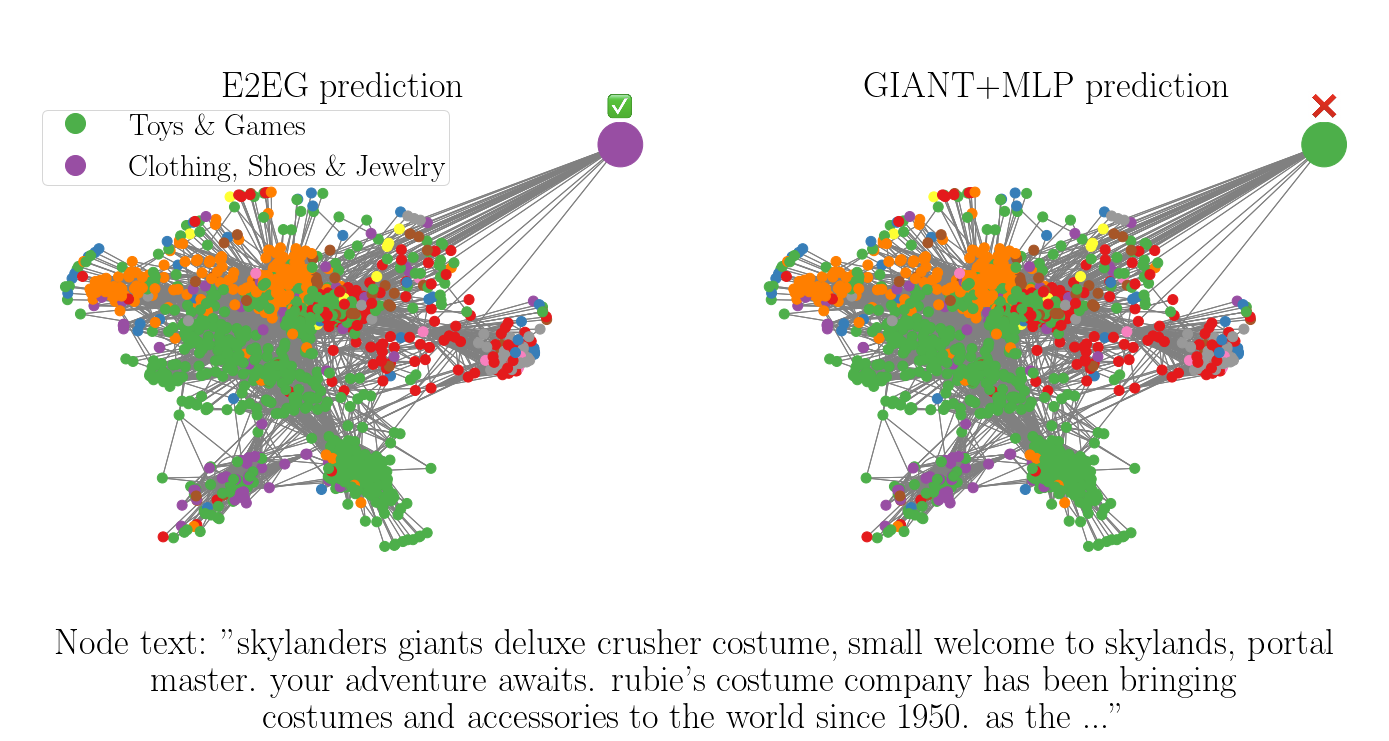

In [60]:
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 30, 'font.weight': 'regular', 'font.family': 'Times Roman'})

if data_name == 'arxiv':
    correct_wrong_zoom = 0.25
    correct_wrong_location_shift = np.array([0, 0.17])
    legend_loc = (0.03,0.7)
    color_scheme = 'viridis'
    giant_pred_class_name = compare_df.loc[central_node, "giant_pred"][:16] + '\n' + compare_df.loc[central_node, "giant_pred"][16:]
elif data_name == 'products':
    correct_wrong_zoom = 0.25
    correct_wrong_location_shift = np.array([0, 0.19])
    legend_loc = (0.03,0.75)
    color_scheme = "Set1"
    giant_pred_class_name = compare_df.loc[central_node, "giant_pred"]
    
    
unique_node_class = np.unique(data.y[node_subset.numpy()].numpy().flatten())
reindex_node_classes = [np.where(unique_node_class == x)[0][0] for x in data.y[node_subset.numpy()].numpy().flatten()]

cmap = cm.get_cmap(color_scheme)
norm = Normalize(vmin=0, vmax=len(unique_node_class) + 1)
color_map_all = {node_class: cmap(norm(node_class)) for node_class in range(0, len(unique_node_class) + 1)}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle(f'Node text: \"{" ".join(compare_df.loc[central_node, "X_text"].split()[:10])} \n{" ".join(compare_df.loc[central_node, "X_text"].split()[10:20])} \n{" ".join(compare_df.loc[central_node, "X_text"].split()[20:30])} ...\"', 
             y=-0.01)
np.random.seed(1)

normal_node_size = 100
node_sizes = np.ones((node_subset.shape[0],) ) * normal_node_size
node_sizes[np.where(node_subset.numpy() == central_node)[0][0]] = normal_node_size*20

my_pred_central_node_class = map_classID_className[map_classID_className == compare_df.loc[central_node, "my_pred"]].index[0]
giant_pred_central_node_class = map_classID_className[map_classID_className == compare_df.loc[central_node, "giant_pred"]].index[0]

reindex_my_pred_central_node_class = np.where(unique_node_class == my_pred_central_node_class)[0][0]
reindex_giant_pred_central_node_class = np.where(unique_node_class == giant_pred_central_node_class)[0][0]

color_map_mine = [color_map_all[x] for x in reindex_node_classes]
color_map_giant = [color_map_all[x] for x in reindex_node_classes]
color_map_giant[np.where(node_subset.numpy() == central_node)[0][0]] = \
        color_map_all[reindex_giant_pred_central_node_class]

center_loc = np.array([1,1])

pos=nx.spring_layout(G)
pos[central_node] = center_loc


nx.draw(G, node_size=node_sizes, pos=pos, edge_color='gray', node_color=color_map_mine, ax=ax1)
nx.draw(G, node_size=node_sizes, pos=pos, edge_color='gray', node_color=color_map_giant, ax=ax2)
ax1.set_title("E2EG prediction")
ax2.set_title("GIANT+MLP prediction")

# reading the image
correct = plt.imread('../visualization/analysis/correct.png')
wrong = plt.imread('../visualization/analysis/wrong.png')
# OffsetBox
correct_box = OffsetImage(correct, zoom=correct_wrong_zoom)
wrong_box = OffsetImage(wrong, zoom=correct_wrong_zoom)

ab = AnnotationBbox(correct_box, center_loc + correct_wrong_location_shift, frameon=False)
ax1.add_artist(ab)

ab = AnnotationBbox(wrong_box, center_loc + correct_wrong_location_shift, frameon=False)
ax2.add_artist(ab)

legend_elements = [Line2D([0], [0], marker='o', color=color_map_all[reindex_giant_pred_central_node_class], 
                          label=giant_pred_class_name.replace('&', '\&'),
                          markerfacecolor=color_map_all[reindex_giant_pred_central_node_class],
                          markersize=20, linestyle=""),
                  Line2D([0], [0], marker='o', color=color_map_all[reindex_my_pred_central_node_class], 
                          label=compare_df.loc[central_node, "my_pred"].replace('&', '\&'),
                          markerfacecolor=color_map_all[reindex_my_pred_central_node_class],
                          markersize=20, linestyle="")]
plt.figlegend(handles=legend_elements, loc=legend_loc, borderpad=0.1)

plt.tight_layout()

plt.savefig(f"../visualization/analysis/GIANTvsE2EG_{data_name}_{central_node}central_{num_hops}hop.pdf",
           bbox_inches='tight')

### Comments:
Among the nodes where E2E predicts correctly and GIANT predicts wrong, 89.34% (for arxiv) and 94.75% (for products) are correctly predicted by BERT (text only). 

It shows that GIANT's doing worse here due to not being able to embed the text directly under the main objective like BERT and E2E.

Samples where E2E predicts correctly and GIANT predicts wrong: neighborhood misleading or unclear, but text is useful
    

In [ ]:
from IPython.display import display
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline  

pd.options.display.float_format = '{:,.2f}'.format

feats = ['node_degrees', "same_neighbor(%)", 'text_length', "class_freq"]
sections = [("e2e_correct_bert_wrong", 'e2e_correct_bert_correct'), ("e2e_correct_giant_wrong", "e2e_correct_giant_correct")]

print_stat = False
plot_stat_hist = False
plot_stat_bar = True
print_shapiro = False  # Test whether the data follows normal distribution
plot_qq = False
print_mannwhitneyu = False  # Test median of the two population
filter_low_class_freq = compare_df["class_freq"] < 0.07 # compare_df["class_freq"].describe()['25%']
compare_df_filtered = compare_df.copy()  # [filter_low_class_freq]


for section in sections:
    for feat in feats:
        if feat in compare_df_filtered.columns:
            if print_stat or print_shapiro or print_mannwhitneyu:
                print(f"{feat}:")
            df = pd.DataFrame({section[0]: compare_df_filtered[result_dict[section[0]]][feat].describe(percentiles=[.01, .25, .5, .75, .99]),
                               section[1]: compare_df_filtered[result_dict[section[1]]][feat].describe(percentiles=[.01, .25, .5, .75, .99])})
            if print_stat:
                display(df)
            if print_shapiro:
                for i in range(0, 2):
                    w, pvalue = stats.shapiro(compare_df_filtered[result_dict[section[i]]][feat])
                    if pvalue < 0.05:
                        print(f"p={pvalue} < 0.05 --> significant --> {feat} of {section[i]} not normally distributed")
            if print_mannwhitneyu:
                # perform two-sided test. You can use 'greater' or 'less' for one-sided test
                result = stats.mannwhitneyu(x=compare_df_filtered[result_dict[section[0]]][feat], 
                                   y=compare_df_filtered[result_dict[section[1]]][feat], 
                                   alternative = 'two-sided')
                print(result)
                print(type(result))
            if plot_qq:
#                 fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
#                 fig.suptitle(f"{feat} - qqplot")
                plt.figure()
                for i in range(0,2):
                    sm.qqplot(compare_df_filtered[result_dict[section[i]]][feat], line ='45')
                    plt.title(section[i] + section[i] + "qqplot")
            if plot_stat_hist:
                fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
                fig.suptitle(f"{feat} - density plot")
                for i in range(0,2):
                    axs[i].hist(compare_df_filtered[result_dict[section[i]]][feat], 
                                bins=100, 
                                range=(df[section[i]]['min'], 
                                       df[section[i]]['99%']),
                                density=True)
                    axs[i].set_title(section[i])
            if plot_stat_bar:
                fig, ax = plt.subplots()
                my_dict = {section[0]: compare_df_filtered[result_dict[section[0]]][feat],
                           section[1]: compare_df_filtered[result_dict[section[1]]][feat]}
                ax.boxplot(my_dict.values(), showfliers=False)
                ax.set_xticklabels(my_dict.keys())
                fig.suptitle(f"{feat} - bar plot")
            if print_stat or print_shapiro or print_mannwhitneyu:
                print("-------------------------------------------------")

### Statistical test to compare the two 
Use nonparametric tests (distribution is not normal, from desity plot, shapiro and qq-plot). But number of samples is too high --> always reject --> not reliable.
Just look at the box plot then.

### Arxiv

- `e2e_correct_bert_wrong` vs `e2e_correct_bert_correct`: 
    - `node_degrees` slighly lower --> counter intuitive --> nodes with more neighbors also have better text description?
    - `same_neighbor(%)` lower --> counter intuitive --> nodes with more similar neighbors also have better text description?
    - `text_length`: slighly higher --> counter intuitive --> ????
    - `class_freq`: **LOWER --> GOOD --> Can classify more difficult samples!!**
    
    

- `e2e_correct_giant_wrong` vs `e2e_correct_giant_correct`: 
    - `node_degrees`: slighly lower 
    - `same_neighbor(%)`: lower
    - `text_length`: higher
    - `class_freq`: **LOWER --> GOOD --> Can classify more difficult samples!!**
    
    
But when avg over runs, no clear difference really, except for `class_freq`


### Products
- `e2e_correct_bert_wrong` vs `e2e_correct_bert_correct`: 
    - `node_degrees`: similar
    - `same_neighbor(%)` lower --> counter intuitive --> nodes with more similar neighbors also have better text description?
    - `text_length`: slighly lower --> doesnt say much
    - `class_freq`: **LOWER --> GOOD --> Can classify more difficult samples!!**
    
    

- `e2e_correct_giant_wrong` vs `e2e_correct_giant_correct`: 
    - `node_degrees`: similar 
    - `same_neighbor(%)`: lower
    - `text_length`: slighly lower --> doesnt say much
    - `class_freq`: **LOWER --> GOOD --> Can classify more difficult samples!!**
